In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything
from pathlib import Path
from skimage.io import imread

seed_everything(12345)
scvi.settings.seed = 12345

/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 12345
Seed set to 12345


# Preparing data

In [2]:
# Preparing variables
# fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/Moran_results/")
# sample = "CyPSCA_1_2"


In [3]:
segmentation_path = Path("/Users/janzules/Roselab/Spatial/CAR_T/data/cell_segmentation/")
adata_file     = segmentation_path / "concatenated" / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/clustering_results/")
ST_sample = sc.read_h5ad(adata_file)

# ST_sample = ST_sample_org[ST_sample_org.obs['mouse'].isin([sample])].copy()
# del ST_sample_org

## Adding images

In [4]:
HNE_TIF_PATHS = {
    "F07839": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA4_Slide_1.tif"),
    "F07840": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA5_Slide_1.tif")
}


In [5]:
ST_sample.obsm["spatial"] = ST_sample.obs[["cx", "cy"]].to_numpy()

In [6]:
# 1) Make sure your AnnData knows which “library” (TMA) each spot comes from.
#    We’ll use your existing 'TMA' column as the library_key:
ST_sample.obs['library_id'] = ST_sample.obs['TMA']

# 2) Build the minimal `adata.uns['spatial']` structure Squidpy expects:
#    For each TMA, point to your H&E image (as a numpy array) and set a scale factor.
ST_sample.uns['spatial'] = {}
for lib_id, tif_path in HNE_TIF_PATHS.items():
    img = imread(tif_path)
    ST_sample.uns['spatial'][lib_id] = {
        "images": {"hires": img},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 100.0,   # <- add this
            "tissue_lowres_scalef": 1.0,      # <- add this (not always needed)
        }
    }

In [7]:
sc.pp.filter_genes(ST_sample, min_counts=3)
sc.pp.filter_cells(ST_sample, min_counts=50)

In [8]:
ST_sample.layers['counts'] = ST_sample.X.copy()

In [9]:
sc.pp.normalize_total(ST_sample, target_sum=1e6)
sc.pp.log1p(ST_sample)

# Dimensionality Reduction

In [10]:
scvi.model.SCVI.setup_anndata(
    ST_sample,
    layer="counts",
    batch_key="library_id"
)

model = scvi.model.SCVI(ST_sample)

In [11]:
model.train(early_stopping=True, enable_progress_bar=True, accelerator="mps")

/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 47/47: 100%|█| 47/47 [24:07<00:00, 30.78s/it, v_num=1, train_loss_step=1.1

`Trainer.fit` stopped: `max_epochs=47` reached.


Epoch 47/47: 100%|█| 47/47 [24:07<00:00, 30.79s/it, v_num=1, train_loss_step=1.1


In [12]:
ST_sample.obsm['X_scVI'] = model.get_latent_representation(ST_sample).astype(np.float32)

In [13]:
sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True)

# CellCharter's spatial clustering

In [14]:
# grabbing coords for CyPSCA_1_2

# Adjust this column name if needed
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# Extract (cx, cy) coordinates
coords = subset.obsm['spatial']

# Compute bounding box
xmin = np.min(coords[:, 0])
xmax = np.max(coords[:, 0])
ymin = np.min(coords[:, 1])
ymax = np.max(coords[:, 1])

print(f"xmin: {xmin}, xmax: {xmax}")
print(f"ymin: {ymin}, ymax: {ymax}")


xmin: 3116.4631871012366, xmax: 8908.762357234882
ymin: 3833.2490728455214, ymax: 6528.459009738141


In [15]:
# 1. Subset AnnData for the target mouse/condition
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# 2. Extract spatial coordinates
coords = subset.obsm['spatial']
xmin, xmax = coords[:, 0].min(), coords[:, 0].max()
ymin, ymax = coords[:, 1].min(), coords[:, 1].max()

# Optional: Add margin (e.g., 100 pixels on each side)
margin = 100
crop_coord = (
    int(xmin - margin),
    int(ymin - margin),
    int(xmax + margin),
    int(ymax + margin)
)

print("Crop coordinates:", crop_coord)


Crop coordinates: (3016, 3733, 9008, 6628)


In [16]:
# Get the unique TMA(s) that contain this mouse
ST_sample.obs.loc[ST_sample.obs['mouse'] == 'CyPSCA_1_2', 'TMA'].unique()

['F07840']
Categories (2, object): ['F07839', 'F07840']

/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


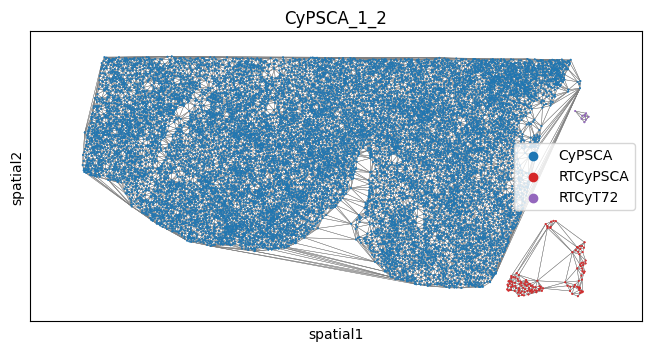

In [17]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [18]:
cc.gr.remove_long_links(ST_sample)

/Users/janzules/anaconda3/envs/spatial_analysis_env2/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


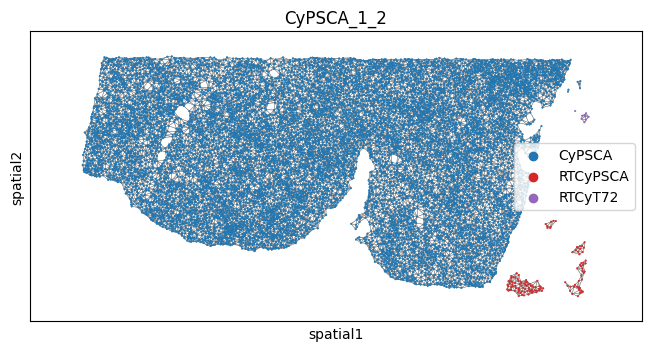

In [19]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [22]:
output = segmentation_path / "scvi_all.h5ad"

In [23]:
ST_sample.write(output)

# Clustering

In [32]:
sq.gr.spatial_neighbors(ST_sample, library_key='library_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

In [33]:
cc.gr.aggregate_neighbors(ST_sample, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.59it/s]


In [34]:
autok = cc.tl.ClusterAutoK(
    n_clusters=(2,10), 
    max_runs=10,
    convergence_tol=0.001
)

In [ ]:
autok.fit(ST_sample, use_rep='X_cellcharter')

Iteration 1/10


  0%|                                                    | 0/11 [00:00<?, ?it/s]